## Пердсказание погоды RNN

### Библиотеки

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, Flatten, LSTM, GRU, Dropout, Conv1D, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.utils import to_categorical, load_img, img_to_array
from tensorflow import keras
import tensorflow as tf

from matplotlib import pyplot as plt
import numpy as np

### Загрузка датасета

In [2]:
fname = os.path.join("jena_climate_2009_2016.csv")
with open(fname) as f:
    data = f.read()
    
lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines), lines[1])

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451 01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10


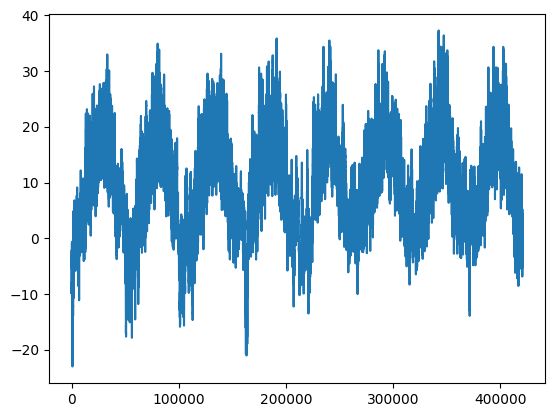

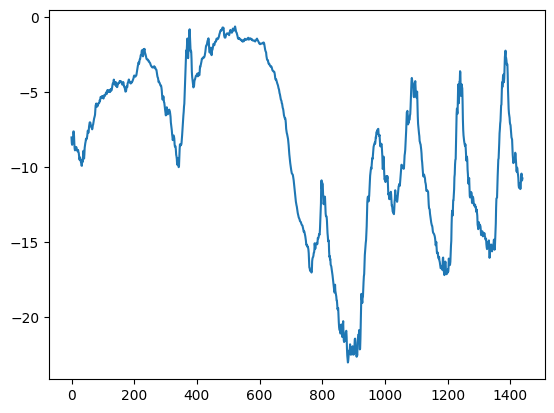

In [3]:
temperature = np.zeros((len(lines),))               # (420451, 1)
raw_data = np.zeros((len(lines), len(header) - 1))  # (420451, 14)
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]
    
# print(raw_data)
# print(temperature)
plt.plot(range(len(temperature)), temperature)
plt.show()
plt.plot(range(1440), temperature[:1440])
plt.show()

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


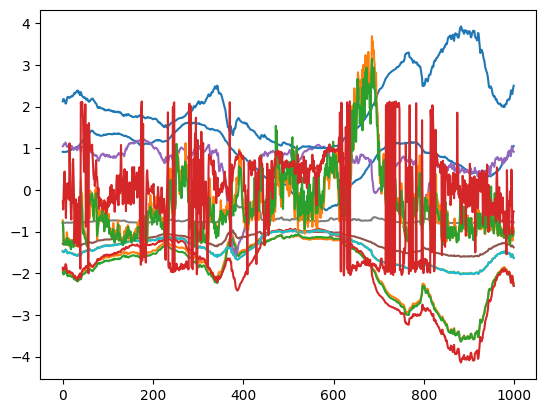

In [4]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

plt.plot(range(len(raw_data[:1000])), raw_data[:1000])
plt.show()

In [5]:
# Sample `timeseries_dataset_from_array`
int_sequence = np.arange(20)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-2],
    targets=int_sequence[6:],
    sequence_length=3,
    sampling_rate=2,
    batch_size=2)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 2, 4] 6
[1, 3, 5] 7
[2, 4, 6] 8
[3, 5, 7] 9
[4, 6, 8] 10
[5, 7, 9] 11
[6, 8, 10] 12
[7, 9, 11] 13
[8, 10, 12] 14
[9, 11, 13] 15
[10, 12, 14] 16
[11, 13, 15] 17
[12, 14, 16] 18


In [6]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
BATCH_SIZE = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True, batch_size=BATCH_SIZE,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True, batch_size=BATCH_SIZE,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True, batch_size=BATCH_SIZE,
    start_index=num_train_samples + num_val_samples)

In [7]:
# for inputs, targets in train_dataset.take(1):
#     for i in range(1):
#         print([x for x in inputs[i]], float(targets[i]))

for samples, targets in train_dataset.take(1):
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)

samples shape: (256, 120, 14)
targets shape: (256,)


### Models

- Idiot Pro

In [8]:
# MAE loss
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_count = 0
    for samples, targets in dataset:  # temperature id=1
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_count += samples.shape[0]
    return total_abs_err / samples_count

# Ошибка в градусах
print(f"Train MAE: {evaluate_naive_method(train_dataset):.2f}")
print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Train MAE: 2.69
Validation MAE: 2.44
Test MAE: 2.62


- Dense

In [52]:
model = Sequential([
    Input(shape=(sequence_length, 14)),
    Flatten(),
    Dense(32, activation="relu"),
    Dense(32, activation="relu"),
    Dense(1),
], name="dense")

- Conv1D

In [69]:
model = Sequential([
    Input(shape=(None, 14)),  # sequence_length =~ None
    Conv1D(16, 24, activation="relu"),
    MaxPooling1D(2),
    Conv1D(32, 12, activation="relu"),
    MaxPooling1D(2),
    Conv1D(32, 6, activation="relu"),
    GlobalAveragePooling1D(),
    Dense(32, activation="relu"),
    Dense(1),
], name="conv1d")

- RNN

In [12]:
model = Sequential([
    Input(shape=(sequence_length, 14)),  # sequence_length =~ None
#     LSTM(32),
    keras.layers.Bidirectional(LSTM(32)), Dropout(0.4),
    Dense(1),
], name="lstm")

- Double RNN

In [10]:
model = Sequential([
    Input(shape=(sequence_length, 14)),  # sequence_length =~ None
    GRU(32, recurrent_dropout=0.3, unroll=True, return_sequences=True),
    GRU(32, recurrent_dropout=0.3, unroll=True),
    Dropout(0.4),
    Dense(1),
], name="2gru")

### Train model

In [13]:
callbacks = [ 
    keras.callbacks.ModelCheckpoint(
        model.name + ".keras",
        monitor="val_loss",
        save_best_only=True)]

model.compile(optimizer=RMSprop(0.0007), loss="mse", metrics=["mae"])
model.summary()

history = model.fit(train_dataset, epochs=15,
                    validation_data=val_dataset, callbacks=callbacks)

model = load_model("lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Model: "lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 64)               12032     
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 12,097
Trainable params: 12,097
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
819/819 [==============================] - 19s 20ms/step - loss: 23.7523 - mae: 3.5782 - val_loss: 10.3271 - val_mae: 2.5084
Epoch 2/15
819/819 [==============================] - 16s 20ms/step - loss: 11.4329 - mae: 2.6362 - val_loss: 10.1117 - 

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "b--", label="MAE на обучающих данных")
plt.plot(epochs, val_loss, "b", label="MAE на проверочных данных")
plt.title("MAE на обучающих и проверочных данных")
plt.legend()
plt.show()